# Identifying repositories with impact driven technology
Due to time constraints, I utilized ChatGPT to assist in generating the following code. This allowed me to focus on defining a robust metric for identifying 'trending' repositories. The provided example, "repositories that gained X stars in the last week," was not feasible without consistently storing star counts over time.

Alternatively, I propose an approach that avoids the need for recurring requests. By fetching the number of issues created for each repository within the last 30 days, we can effectively quantify the engagement these repositories are receiving.

## Fetching the data

In [2]:
import requests
import pandas as pd
from datetime import datetime, timedelta

# GitHub API base URL
GITHUB_API_URL = "https://api.github.com/search/repositories"

# Time window: last two years
two_years_ago = (datetime.now() - timedelta(days=2*365)).strftime('%Y-%m-%d')

# Time window for issues created in the last week
one_week_ago = (datetime.now() - timedelta(days=7)).isoformat()

# Time window for issues created in the last month
one_month_ago = (datetime.now() - timedelta(days=30)).isoformat()

# Query parameters for GitHub API
query = f'created:>{two_years_ago} stars:>100 (sustainability OR education OR health OR "clean energy" OR climate)'

# Request headers (optional GitHub token to avoid rate limits)
headers = {
    'Accept': 'application/vnd.github.v3+json',
    'Authorization': 'token <YOUR_GITHUB_TOKEN>' # Optional for higher rate limits
}

# Collecting results from multiple pages
repositories = []
page = 1

while True:
    params = {
        'q': query,
        'sort': 'stars',
        'order': 'desc',
        'per_page': 100,
        'page': page
    }
    
    # API request
    response = requests.get(GITHUB_API_URL, headers=headers, params=params)
    
    if response.status_code != 200:
        print(f"Error: {response.status_code}, {response.json().get('message')}")
        break
    
    # Parse the JSON response
    result = response.json()
    repositories.extend(result['items'])
    
    # Check if there are more pages
    if 'next' not in response.links:
        break
    
    page += 1

# Function to get the most used programming language of a repository
def get_most_used_language(languages_url):
    response = requests.get(languages_url, headers=headers)
    if response.status_code == 200:
        languages = response.json()
        if languages:
            # Get the most used language based on the highest byte count
            return max(languages, key=languages.get)
    return None

# Function to get the number of issues created in the last week
def get_recent_issues_count(issues_url):
    params = {
        'since': one_month_ago
    }
    response = requests.get(issues_url, headers=headers, params=params)
    if response.status_code == 200:
        issues = response.json()
        return len(issues)
    return 0

# Extract the required fields and fetch the most used language and recent issues count
data = []
for repo in repositories:
    repo_data = {
        'name': repo['name'],
        'description': repo['description'],
        'stars': repo['stargazers_count'],
        'created_at': repo['created_at'],
        'url': repo['html_url'],
        'most_used_language': get_most_used_language(repo['languages_url']),
        'recent_issues_count': get_recent_issues_count(repo['issues_url'].replace('{/number}', ''))
    }
    data.append(repo_data)

# Convert to DataFrame
df = pd.DataFrame(data)


## Analysis
Since we have already retrieved the most-used language for each repository and added this information to the data frame, identifying the top five languages across all repositories becomes straightforward.

In [1]:
# Find the top 5 most used languages
language_counts = df['most_used_language'].value_counts()

# Get the top 5 most used languages
top_5_languages = language_counts.head(6)
top_5_languages

NameError: name 'df' is not defined

For the bonus and because it is so easy with Jupyter Notebook here is the simplest visualisation possible

<Axes: xlabel='most_used_language'>

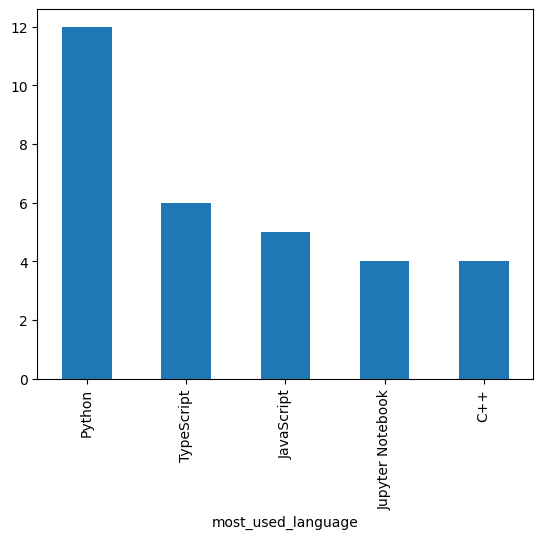

In [69]:
top_5_languages.plot.bar()

Average number of stars is

In [103]:
df['stars'].mean()

np.float64(1632.76)

The repositories with the highest star counts are listed below, as we had previously requested the GitHub API to sort the results in descending order by stars.

In [63]:
df.head(3)

,name,description,stars,created_at,url,most_used_language
0,hello-algo,"《Hello 算法》：动画图解、一键运行的数据结构与算法教程。支持 Python, Java...",95608,2022-11-04T11:08:34Z,https://github.com/krahets/hello-algo,Java
1,Mr.-Ranedeer-AI-Tutor,A GPT-4 AI Tutor Prompt for customizable perso...,28530,2023-03-31T12:37:26Z,https://github.com/JushBJJ/Mr.-Ranedeer-AI-Tutor,None
2,Doctor-Dignity,Doctor Dignity is an LLM that can pass the US ...,3841,2023-08-06T18:02:55Z,https://github.com/llSourcell/Doctor-Dignity,Python


The task instructed me to store the result in a file rather than in the output of this notebook. However, I opted for this approach as it provides a more human-readable format and encourages users to interact with the data. Additionally, this allowed me to allocate more time to the remaining task.

## Augmenting the data with AI

Again ChatGPT gave me a good starting point but I didn't have the time to test this at all:

In [72]:
import openai
openai.api_key = <OPENAI_API_KEY>

def summarize_description(description):
    try:
        response = openai.Completion.create(
            engine="text-davinci-003",  # You can change the model if needed
            prompt=f"Summarize the following repository description highlighting the potential positive impact: {description}",
            max_tokens=50,
            n=1,
            stop=None,
            temperature=0.7,
        )
        summary = response.choices[0].text.strip()
        return summary
    except Exception as e:
        return f"Error summarizing description: {e}"

I then utilized this data to add a new column to the DataFrame, which contains the summary of each repository's description.

In [ ]:
df['description_summary'] = df['description'].apply(summarize_description)

To generate a VC impact score I also used the OpenAI API and came up with a prompt that should return (I have not tested this properly since I was out of time) a json that has keys for each UN sustainable development goal and a value between 0 and 5 that represent the repositories impact in that regard.

In [ ]:
def rate_sdg_alignment(description):
    try:
        response = openai.Completion.create(
            engine="text-davinci-003",  # You can change the model if needed
            prompt=f"Evaluate the description of this Github repository based on its alignment with the 17 UN Sustainable Development Goals and return a json with values from 0 to 5 for each: {description}",
            max_tokens=50,
            n=1,
            stop=None,
            temperature=0.7,
        )
        summary = response.choices[0].text.strip()
        return summary
    except Exception as e:
        return f"Error summarizing description: {e}"